Author: Thibeau Wouters

# Physical Modelling of Complex Systems - Assignment 8

##### Import packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [2]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (8, 4),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
     "legend.fontsize":24,
    "lines.markersize" : 10,
     "legend.fontsize": 16,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

## 8.1 - Fisher-Kolmogorov equation

### 8.1.2 - Numerical integration

In [3]:
def u_in(x):
    '''Function that gives the initial condition at a point x for exercise 8.1'''
    
    return np.exp(- x**2)/2

In [4]:
def get_x_values(a, b, N):
    '''Gives the x-values and separation in the partition, of length N, of the interval a, b'''
    
    x_vals= np.linspace(a, b, N)
    DeltaX = abs(x_vals[1] - x_vals[0])
    
    return x_vals, DeltaX

In [5]:
def logistic_func(x):
    '''The reaction in the FK eq'''
    
    return x*(1-x)

Note: relative to the assignment, all $u$ values have their index number one lower in this notebook (e.g. $u_1$ in the assignment is $u_0$ in this notebook). The reason is that Python starts indexing from 0 rather than 1. Hence $u_N$ becomes $u_{N-1}$ et cetera.

The optional argument 'reaction' in the following three functions allows one to turn off the reaction part (set it to zero) of the differential equations. We can use this to only focus on diffusion, to check our numerical integration scheme. Only set it to zero or one!

In [6]:
def u_0_dot(u0, u1, DeltaX, reaction_func = logistic_func, reaction = 1):
    '''Differential equation for u0 (see assignment)'''
    
    return ((1/DeltaX)**2)*(u1 - u0) + reaction*reaction_func(u0)

In [7]:
def u_n_dot(unm1, un, unp1, DeltaX, reaction_func = logistic_func, reaction = 1):
    '''Differential equation for un (see assignment): unm1 is u_{n-1}, unp1 is u_{n+1}'''
    
    return ((1/DeltaX)**2)*(unp1 - 2*un + unm1) + reaction*reaction_func(un)

In [8]:
def u_Nm1_dot(uNm2, uNm1, DeltaX, reaction_func = logistic_func, reaction = 1):
    '''Differential equation for u_N-1 (see assignment)'''
    
    return ((1/DeltaX)**2)*(uNm2 - uNm1) + reaction*reaction_func(uNm1)

In [9]:
def solve_PDE(a, b, N, in_func, t_vals, reaction_func = logistic_func, reaction = 1):
    '''Solves a reaction-diffusion PDE by discretizing space and time'''
        
    # Get x values and Delta X separation for partition of [a, b] in N parts
    x_vals, DeltaX = get_x_values(a, b, N)
    
    # Return values: dictionary with at each x_n point, the list of u_n points, for all times
    return_values = {}
    
    # Last values:  when a new value at x_n is computed, store it for the next calculation (faster computations)
    last_values = {}
    
    # Get the initial condition (first computed values) and save in the dicts
    initial = in_func(x_vals)
    for i in range(N):
        return_values[i] = [initial[i]]
        last_values[i] = initial[i]
    
    # Get the value of Delta t for calculations
    DeltaT = abs(t_vals[1] - t_vals[0])
    
    # Compute all the other values at all other times
    for t in t_vals:
        if t == t_vals[0]:
            
            # Initial condition: already added, so do nothing in this step
            pass
            
        else:
            for i in range(N):
                if i == 0:
                    
                    new_u0_value = last_values[0] + u_0_dot(last_values[0], last_values[1], DeltaX, reaction_func, reaction)*DeltaT
                    return_values[i].append(new_u0_value)
                    last_values[i] = new_u0_value
                    
                elif i == N-1:
                    
                    new_uNm1_value = last_values[i] + u_Nm1_dot(last_values[i - 1], last_values[i], DeltaX, reaction_func, reaction)*DeltaT
                    return_values[i].append(new_uNm1_value)
                    last_values[i] = new_uNm1_value
                    
                else: # 1 <= i <= N-2
                    
                    new_un_value = last_values[i] + u_n_dot(last_values[i-1], last_values[i], last_values[i+1], DeltaX, reaction_func, reaction)*DeltaT
                    return_values[i].append(new_un_value)
                    last_values[i] = new_un_value
            
    return return_values, x_vals

In [10]:
def get_y_values(values, x_vals, index = -1):
    '''Get the numerical values at a certain index (time). Default is last computed value.'''
    
    # Get the final value for each x point
    y_vals = []
    for i in range(len(x_vals)):
        y_vals.append(values[i][index])
    
    return y_vals

Test by turning off the reaction, so we just have diffusion. In that case, the result can be computed analytically:

In [11]:
def analytic_solution_diffusion(x, t):
    '''Analytic solution when reaction is turned off (see report)'''
    
    return (1/(2*np.sqrt(4*t + 1)))*np.exp(-x**2/(4*t+1))

The comparison is done below:

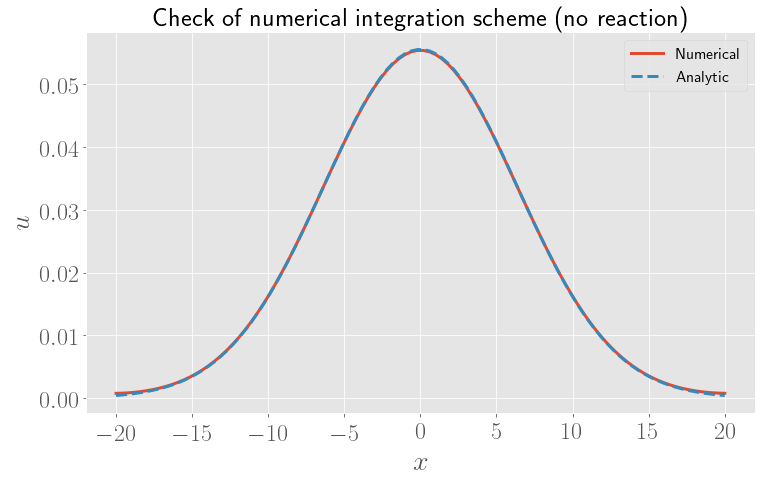

In [12]:
a = -20; b = 20; N = 100
t_vals = np.arange(0, 20, 0.001)

plt.figure(figsize = (12, 7))

# Get numerical values
values, x_vals = solve_PDE(a, b, N, u_in, t_vals, reaction = 0)
y_vals = get_y_values(values, x_vals)
plt.plot(x_vals, y_vals, label = 'Numerical')

# Compare with analytic values
last_t = t_vals[-1]
analytic_vals = analytic_solution_diffusion(x_vals, last_t)
plt.plot(x_vals, analytic_vals, '--', label = 'Analytic')

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend()
plt.title('Check of numerical integration scheme (no reaction)')
plt.savefig('check_numerical_scheme.pdf', bbox_inches = 'tight')
plt.show()

Seems OK: now integrate using the reaction as well.

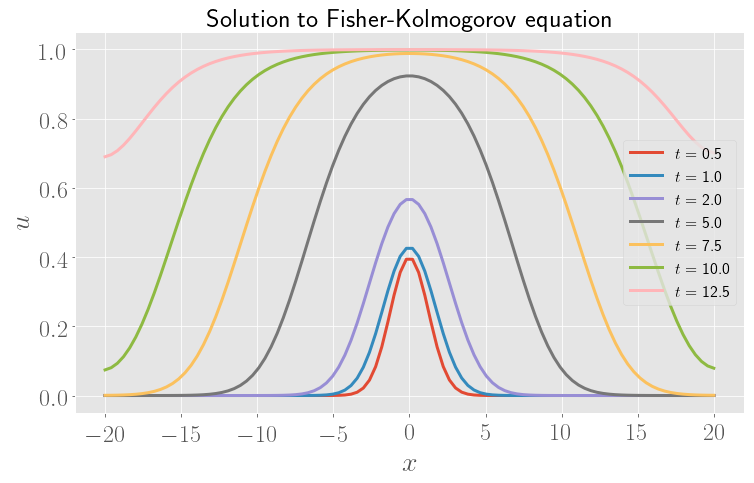

In [13]:
a = -20; b = 20; N = 100

# Choose values of t we want to compute
end_t_list = [0.5, 1, 2, 5, 7.5, 10, 12.5]

# Plot
plt.figure(figsize = (12, 7))
for t in end_t_list:
    t_vals = np.arange(0, t, 0.001)

    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals, label = '$t = $ % 0.1f' % t)

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend()
plt.title('Solution to Fisher-Kolmogorov equation')
plt.savefig('8_1_wave_solution.pdf', bbox_inches = 'tight')
plt.show()

### 8.1.2 - Estimate the speed

Now, estimate the speed from the above solutions...

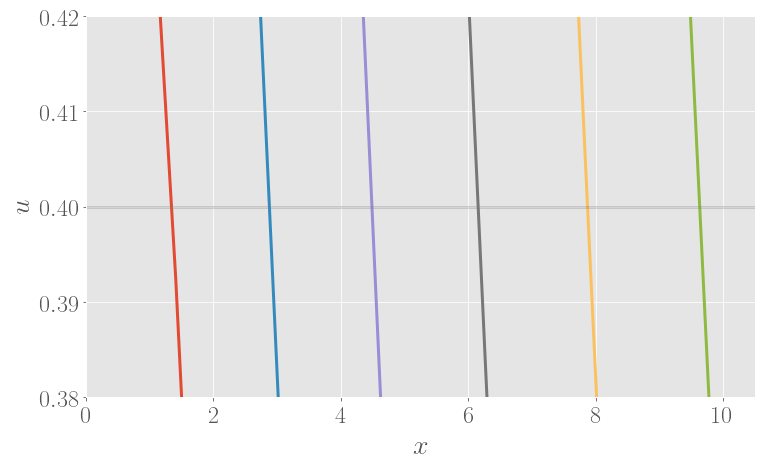

In [14]:
a = -20; b = 20; N = 100

# Choose values of t we want to compute
end_t_list = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5]

plt.figure(figsize = (12, 7))
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)

    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals)

plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

# Change the plot to easily find where the plot equals 0.4
plt.xlim(0, 10.5)
plt.ylim(0.38, 0.42)
plt.axhline(y = 0.4, color = 'grey', alpha = 0.3)
plt.savefig('8_1_determine_speed.pdf', bbox_inches = 'tight')
plt.show()

Now try to get the speed more precisely by doing it numerically. $ \textbf{Note:} $ This is not working very well and can cause errors!

In [15]:
def get_x_A_list(values, x_vals, A = 0.3):
    '''Estimates the speed of a wave from a numerical computation.'''
    
    x_A_list = []
    
    # Only look at x > 0 so define a starting index
    start_index = 0
    for val in x_vals:
        if val < 0:
            start_index += 1
        else:
            break
            
    
    for i in range(len(values[0])): # for all times
        u_vals = get_y_values(values, x_vals, i) # get u values at this time
        smaller_than_A = False
        index = start_index
        
        # Check when the solution crosses u = A, save the corresponding x location
        while smaller_than_A == False:
            if u_vals[index]< A:
                smaller_than_A = True
                x_A_list.append(x_vals[index])
            
            else:
                index += 1
        
    return x_A_list

In [16]:
def estimate_speed(x_A_list, DeltaT):
    '''From a list of x_A locations, estimate the speed'''
    
    speeds = []
    
    for i in range(len(x_A_list) - 1):
        DeltaX = abs(x_A_list[i+1] - x_A_list[i])
        speeds.append(DeltaX/DeltaT)
        
    # Return all speeds, so we can plot the speeds and check them
    return speeds

We have to improve on our partition of the interval $[a, b]$ to get a better estimate for the speed. However, this requires more computational effort, and can potentially give errors during the calculation (use the code block above to check the numerical integration scheme for $N = 400$: there are large errors).

In [17]:
t_vals = np.arange(0, 10, 0.001)
a = -20; b = 20; N = 400

values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
x_A_list = get_x_A_list(values, x_vals, A = 0.35)

# Only compute speed if  we found a x_A value for all t values 
if len(t_vals) == len(x_A_list):
    DeltaT = abs(t_vals[1] - t_vals[0])
    speeds = estimate_speed(x_A_list, DeltaT)

    print('The speed of the wave is', np.mean(speeds))

The speed of the wave is 1.824743877896561


### 8.1.3 - Approximate solution

In [18]:
def approximate_solution(x, t, c = 2):
    '''Approximate solution from the assignment'''
    
    return 1/(1 + np.exp((x - c*t)/c))

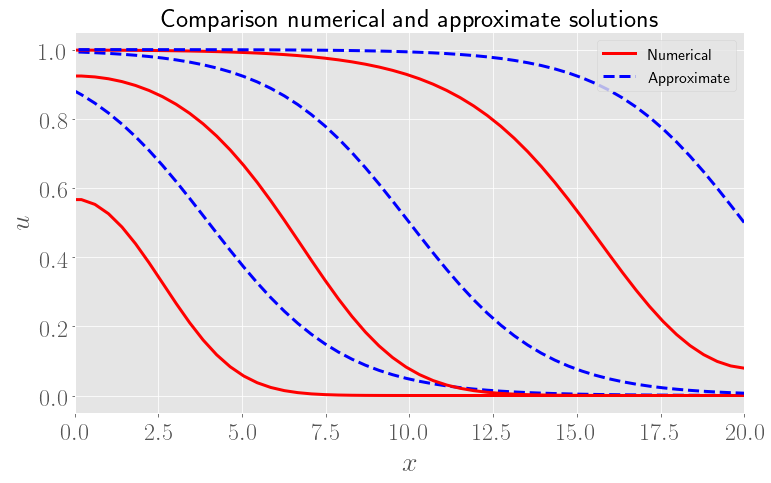

In [19]:
a = -20; b = 20; N = 100

plt.figure(figsize = (12, 7))
end_t_list = [2, 5, 10]

for t in end_t_list:
    t_vals = np.arange(0, t, 0.001)
    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals, reaction = 1)
    y_vals = get_y_values(values, x_vals)
    
    if t == end_t_list[0]:
        plt.plot(x_vals, y_vals, color = 'red', label = 'Numerical')
    else:
        plt.plot(x_vals, y_vals, color = 'red')

    # Compare with approximate solution
    last_t = t_vals[-1]
    approximate_vals = approximate_solution(x_vals, last_t)
    
    if t == end_t_list[0]:
        plt.plot(x_vals, approximate_vals, '--', color = 'blue', label = 'Approximate')
    else:
        plt.plot(x_vals, approximate_vals, '--', color = 'blue')

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, b)
plt.legend()
plt.title('Comparison numerical and approximate solutions')
plt.savefig('8_1_comparison_approx.pdf', bbox_inches = 'tight')
plt.show()

Compare the two initial conditions.

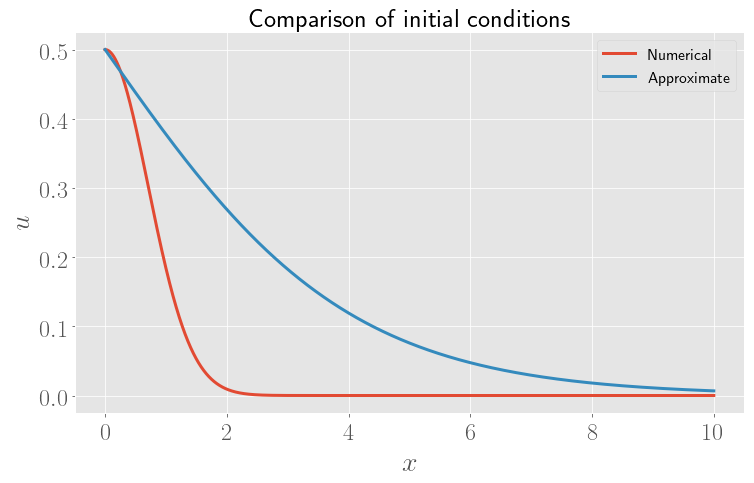

In [20]:
x_vals = np.arange(0, 10, 0.001)

# Get initial conditions
y_vals_1 = u_in(x_vals)
y_vals_2 = approximate_solution(x_vals, 0)

# Plot, make fancy, save and show
plt.figure(figsize = (12, 7))
plt.plot(x_vals, y_vals_1, label = 'Numerical')
plt.plot(x_vals, y_vals_2, label = 'Approximate')
plt.title('Comparison of initial conditions')
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend()
plt.savefig('8_1_comparison_initial_conds.pdf', bbox_inches = 'tight')
plt.show()

The approximate solution appeared to be faster than the numerically integrated one... Let us check this! (Not given in report)

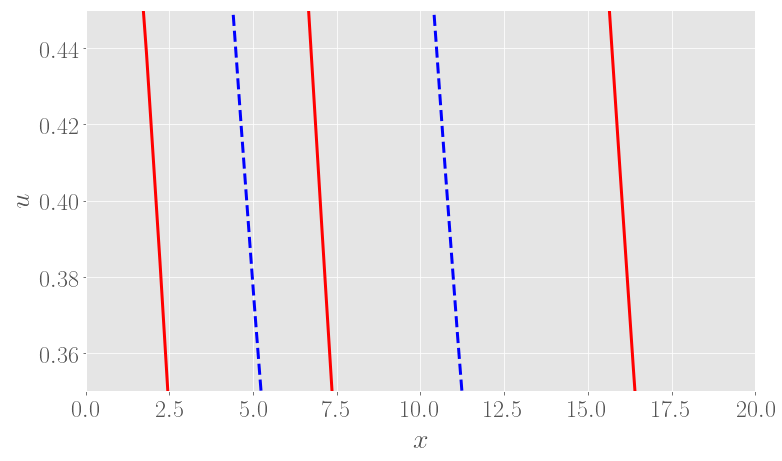

In [21]:
a = -20; b = 20; N = 100
x_vals = np.arange(0, 20, 0.001)

plt.figure(figsize = (12, 7))

# Choose t values we want to explore
end_t_list = [2, 5, 10]
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)
    last_t = t_vals[-1]

    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals, color = 'red')

    # Get special solution
    approx_vals = approximate_solution(x_vals, last_t)
    plt.plot(x_vals, approx_vals, '--', color = 'blue')

# Make fancy, save and show?
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, 20)
plt.ylim(0.35, 0.45)
#plt.legend()
#plt.savefig('8_3_comparison_waves.pdf', bbox_inches = 'tight')
plt.show()

## 8.2 - Traveling waves in bistable system

In [22]:
def get_eigenvalues(c, a = 1/4):
    '''Gives the eigenvalues for the FP (1, 0)'''
    
    lambda_plus = 0.5*(-c + np.sqrt(c**2 - 4*a + 4))
    lambda_minus = 0.5*(-c - np.sqrt(c**2 - 4*a + 4))
    
    return lambda_plus, lambda_minus

In [23]:
def get_eigenvectors(lambda_plus, lambda_minus):
    '''Get the eigenvectors for FP (1, 0)'''
    
    v_plus = np.array([1, lambda_plus])
    v_minus = np.array([1, lambda_minus])
    
    return v_plus, v_minus

In [24]:
def magnitude(vector):
    '''Gives the magnitude of a 2D vector (used in plot_eigendirections).'''
    
    return np.sqrt(vector[0]**2 + vector[1]**2) 

In [25]:
def plot_eigendirections(x0, y0, vectors, types,  length = 1, c = 0.85, head_width = 0.006, width = 0.001, markersize = 60):
    '''Plots the eigendirections of a fixed point, type = rep for repulsion (positive eigenval) or attr for attraction (negative eigenvalue).
        c: factor which shortens the two arrows 
        length: length of the two arrows'''

    # Normalise the two vectors with the desired length
    
    vectors_N = []
    
    for vector in vectors:
        normalised_vector =  length*vector/magnitude(vector)
        vectors_N.append(normalised_vector)
    
    # Define other scale factor in function of c
    a = 1-c
    
    # Plot the arrows
    
    for i in range(len(vectors_N)):
        vector_N = vectors_N[i]
        
        # For a repulsion
        if types[i] == 'rep':
            plt.arrow(x0 + a*vector_N[0], y0 + a*vector_N[1],   vector_N[0],    vector_N[1], color = 'black', zorder = 10, width = width, head_width = head_width)
            plt.arrow(x0  - a*vector_N[0], y0  - a*vector_N[1], - vector_N[0], - vector_N[1], color = 'black', zorder = 10, width = width,  head_width = head_width)
        
        # For an attraction
        if types[i] == 'attr':
            plt.arrow(x0 + vector_N[0], y0 + vector_N[1], - c*vector_N[0], - c*vector_N[1], color = 'black', zorder = 10, width = width, head_width = head_width)
            plt.arrow(x0  - vector_N[0], y0  - vector_N[1],    c*vector_N[0],    c*vector_N[1], color = 'black', zorder = 10, width = width, head_width = head_width)

    plt.scatter(x0, y0, color = 'black', s = markersize, zorder = 10)

See the fixed point $(1, 0)$ up close so we can check our eigenvectors:

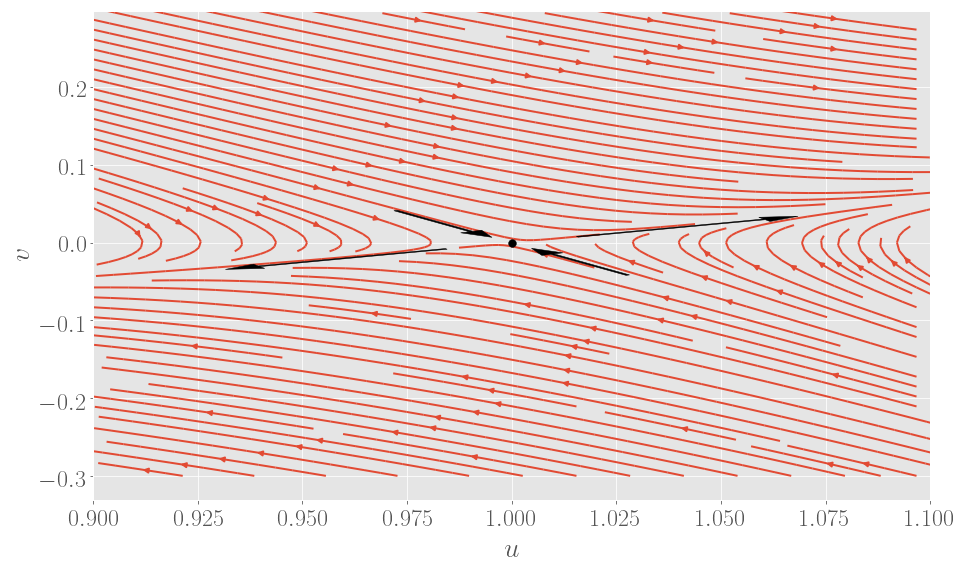

In [26]:
plt.figure(figsize = (15, 9))

c = 1; a = 1/4
# Set up previous phase portrait, focus around fixed point (1,1)
X, Y = np.meshgrid(np.arange(1-0.1, 1+0.1, 0.001), np.arange(-0.3, 0.3, 0.001))
U = Y
V = -c*Y - X*(X - a)*(1 - X)
plt.streamplot(X, Y, U, V, density = 1.6, linewidth = 2)

# Plot the arrows (see function above)
lambda_plus, lambda_minus = get_eigenvalues(c)
v_plus, v_minus = get_eigenvectors(lambda_plus, lambda_minus)
plot_eigendirections(1, 0, [v_plus, v_minus], ['rep', 'attr'], c = 0.65, length = 0.05)

# Make fancy, save and show
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.show()

Looks good! Get a full picture of the phase portrait etc.

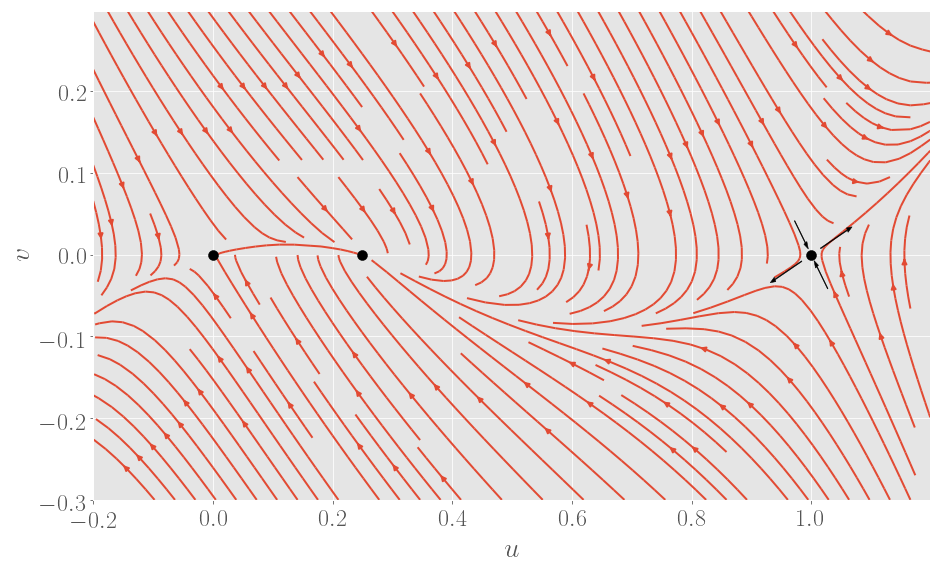

In [27]:
plt.figure(figsize = (15, 9))

c = 1; a = 1/4
# Set up phase portrait
X, Y = np.meshgrid(np.arange(-0.2, 1.2, 0.001), np.arange(-0.3, 0.3, 0.001))
U = Y
V = -c*Y - X*(X - a)*(1 - X)
plt.streamplot(X, Y, U, V, density = 1.4, linewidth = 2)

# Plot the arrows (see function above)
lambda_plus, lambda_minus = get_eigenvalues(c)
v_plus, v_minus = get_eigenvectors(lambda_plus, lambda_minus)
plot_eigendirections(1, 0, [v_plus, v_minus], ['rep', 'attr'], c = 0.65, length = 0.05)

plt.scatter(a, 0, color = 'black', zorder = 10)
plt.scatter(0, 0, color = 'black', zorder = 10)
plt.scatter(1, 0, color = 'black', zorder = 10)

# Make fancy
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.show()

Now, start from an initial condition close to $(1, 0)$ and  try to reach the origin.

In [28]:
def get_initial_condition(lambda_plus, eps = 10**(-2)):
    '''Get a point close to (1, 0) and along the repulsive eigenvector.'''
    
    u0 = 1 - eps
    v0 = - eps*lambda_plus
    
    return u0, v0

In [29]:
def solve_ODE_2D(f, g, t_vals, initial_cond, c):
    '''Solves a 2D system of differential equations.'''
    
    x0 = initial_cond[0]; y0 = initial_cond[1]
    
    x_vals = []
    y_vals = []
    
    DeltaT = abs(t_vals[1] - t_vals[0])
    
    for t in t_vals:
        if t == t_vals[0]: # append the initial condition
            x_vals.append(x0)
            y_vals.append(y0)
            
        else:
            x_val = x_vals[-1] + DeltaT*f(x_vals[-1],  y_vals[-1])
            y_val = y_vals[-1] + DeltaT*g(x_vals[-1], y_vals[-1], c)
            
            x_vals.append(x_val); y_vals.append(y_val)
            
    
    return (x_vals, y_vals)

Define the system of equations for this model

In [30]:
def u_dot(u, v):
    return v

In [31]:
def v_dot(u, v, c, a = 1/4):
    return -c*v - u*(u-a)*(1-u)

After playing around with various plots in the phase plane, it seems a value for $c$ between 0.35 and 0.355 reaches the origin. We search for the best value of $c^*$ numerically as follows.

In [32]:
# Define how we explore the c values
c_vals = np.arange(0.35, 0.355, 0.00001)
t_vals = np.arange(0, 20, 0.001)
eps = 10**(-3)

# Save c values with trajectories that come close to the origin
good_c_vals = []
for c in c_vals:
    lambda_plus, lambda_minus = get_eigenvalues(c)
    u0, v0 = get_initial_condition(lambda_plus)
    u_vals, v_vals = solve_ODE_2D(u_dot, v_dot, t_vals, (u0, v0), c)
    
    if np.sqrt(u_vals[-1]**2 + v_vals[-1]**2) < eps:
        good_c_vals.append(c)

In [33]:
good_c_vals

[0.3536100000000036,
 0.3536200000000036,
 0.3536300000000036,
 0.3536400000000036,
 0.35365000000000363,
 0.35366000000000364,
 0.35367000000000365,
 0.35368000000000366]

So we can expect the best heteroclinic orbit-like behaviour around

In [34]:
c_star = np.round(np.mean(good_c_vals), 5)
print(c_star)

0.35365


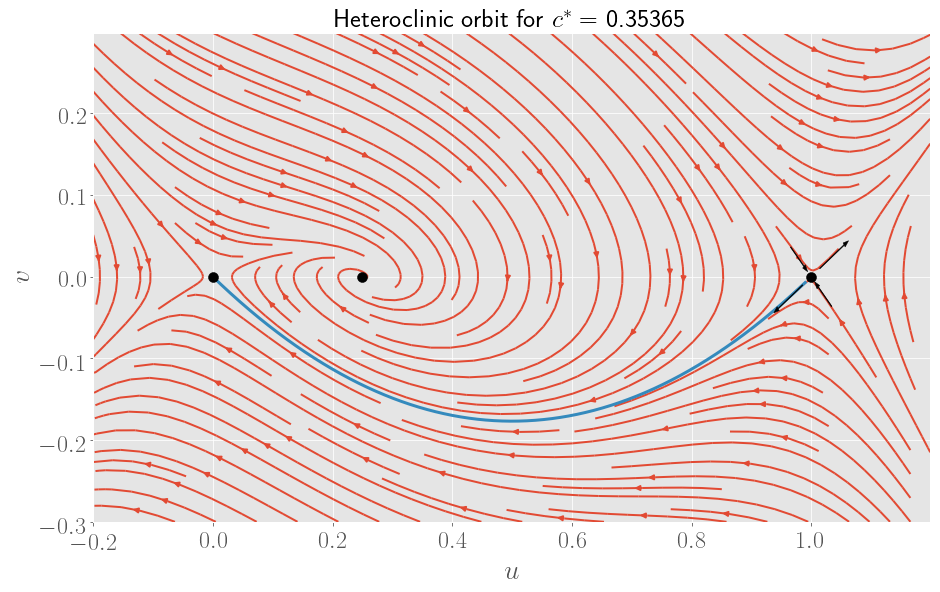

In [35]:
plt.figure(figsize = (15, 9))

a = 1/4

# Set up previous phase portrait
X, Y = np.meshgrid(np.arange(-0.2, 1.2, 0.001), np.arange(-0.3, 0.3, 0.001))
U = Y
V = -c_star*Y - X*(X - a)*(1 - X)
plt.streamplot(X, Y, U, V, density = 1.4, linewidth = 2)

# Plot fixed points and eigendirections
plt.scatter(a, 0, color = 'black', zorder = 10)
plt.scatter(0, 0, color = 'black', zorder = 10)
plt.scatter(1, 0, color = 'black', zorder = 10)
lambda_plus, lambda_minus = get_eigenvalues(c_star)
v_plus, v_minus = get_eigenvectors(lambda_plus, lambda_minus)
plot_eigendirections(1, 0, [v_plus, v_minus], ['rep', 'attr'], c = 0.65, length = 0.05)

# Get the solution (heteroclinic orbit, if c is good)
t_vals = np.arange(0, 20, 0.001)
u0, v0 = get_initial_condition(lambda_plus)
u_vals, v_vals = solve_ODE_2D(u_dot, v_dot, t_vals, (u0, v0), c_star)
plt.plot(u_vals, v_vals)

# Make fancy, save and show
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.title(r'Heteroclinic orbit for $c^* = $ %0.5f' % c_star)
plt.savefig('8_2_heteroclinic_orbit.pdf', bbox_inches = 'tight')
plt.show()

### 8.2.2 - Find a wave with this speed

Define the new type of logistic function, with the extra factor.

In [36]:
def new_logistic_func(u, a = 1/4):
    '''Logistic function, but with the new factor.'''
    
    return u*(u - a)*(1 - u)

In [37]:
def u_in2(x):
    '''Initial condition to find the wave.'''
    
    return 1/(1 + np.exp(x))

This initial condition satisfies the usual boundary conditions of a wavefront (as seen in the lecture, for example).

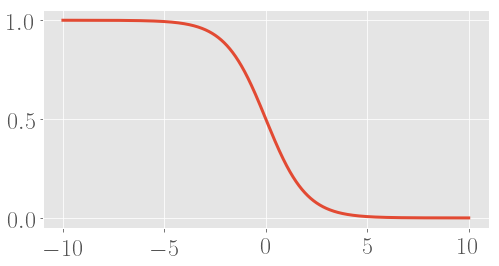

In [38]:
x_vals = np.arange(-10, 10, 0.001)
u_vals = u_in2(x_vals)
plt.plot(x_vals, u_vals)
plt.show()

Determine the speed: see the report for the idea. The separation between $t$ values that we will use is

In [39]:
deltaT = 1/c_star
deltaT

2.8276544606249114

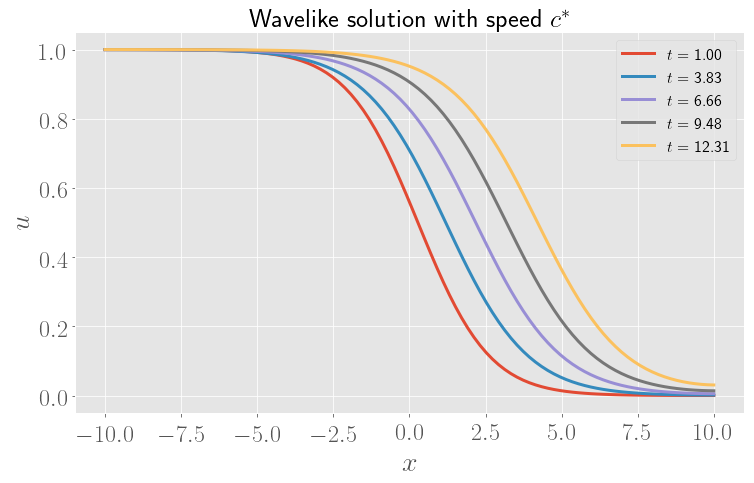

In [40]:
# Define bounds: make them smaller than exercise 1 because wave is much slower
a = -10; b = 10; N = 100

plt.figure(figsize = (12, 7))

# Choose t values we want to explore
end_t_list = np.arange(1, 15, deltaT)
for t in end_t_list:
    t_vals = np.arange(0, t, 0.001)

    # Get numerical values and plot
    values, x_vals = solve_PDE(a, b, N, u_in2, t_vals, reaction_func = new_logistic_func)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals, label = r'$t = $ %0.2f' % t)

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'Wavelike solution with speed $c^*$')
plt.legend()
plt.savefig('8_2_wave_solution.pdf', bbox_inches = 'tight')
plt.show()

To determine the speed of the wave from the numerical calculation, proceed as before, and zoom in.

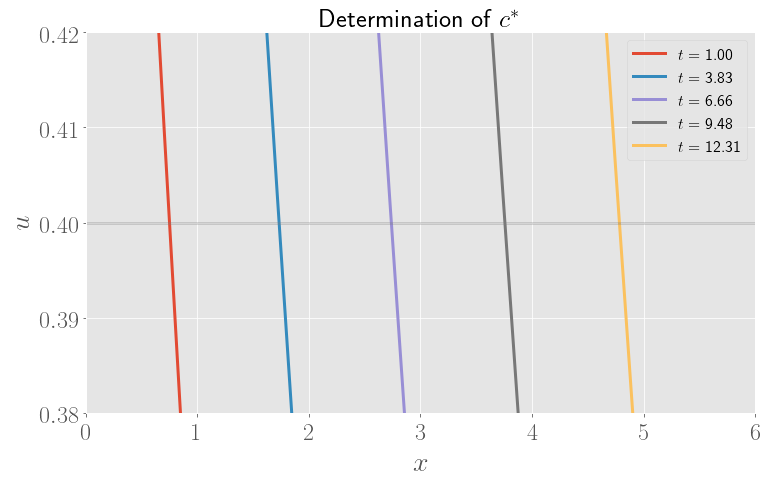

In [41]:
a = -10; b = 10; N = 100

plt.figure(figsize = (12, 7))

# Choose t values we want to explore
end_t_list = np.arange(1, 15, deltaT)
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)

    # Get numerical values and plot
    values, x_vals = solve_PDE(a, b, N, u_in2, t_vals, reaction_func = new_logistic_func)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals, label = r'$t = $ %0.2f' % t)

# Make fancy, save and show - zoom in to easily determine the speed
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, 6)
plt.ylim(0.38, 0.42)
plt.axhline(y = 0.4, color = 'grey', alpha = 0.3)
plt.legend()
plt.title(r'Determination of $c^*$')
plt.savefig('8_2_determine_speed.pdf', bbox_inches = 'tight')
plt.show()

## 8.3 - Special solution of the Fisher-Kolmogorov equation

In [42]:
def special_solution(z, A = 1):
    '''Solution given in the assignment'''
    
    return 1/((1 + A*np.exp(z/np.sqrt(6)))**2)

In [43]:
def dv_special_solution(z, A = 1):
    '''Derivative of the special solution, to plot in the (u, v) plane'''
    
    return - (np.sqrt(2/3)*A*np.exp(z/np.sqrt(6)))/((1 + A*np.exp(z/np.sqrt(6)))**3)

Plot the solution:

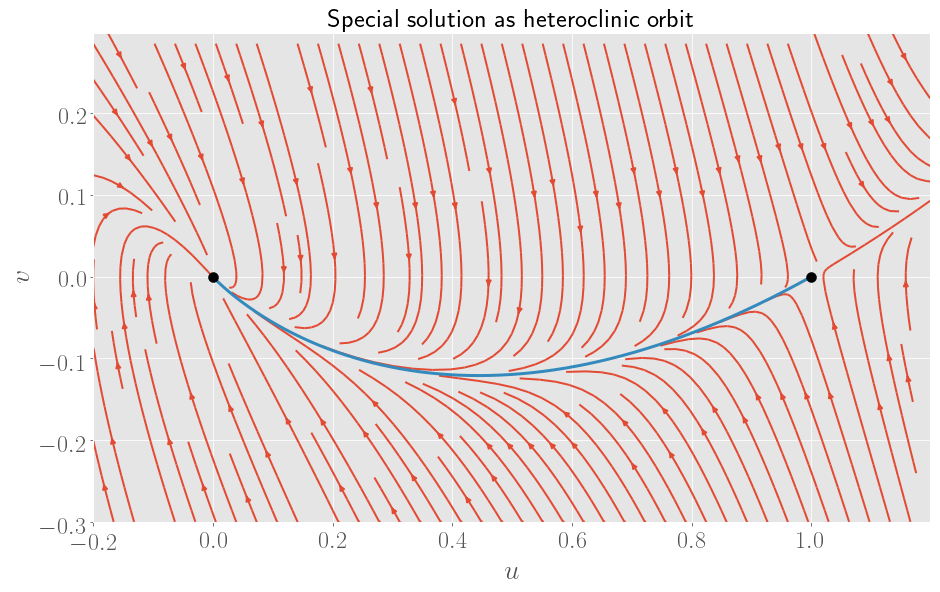

In [44]:
plt.figure(figsize = (15, 9))

c = 5/np.sqrt(6)

# Set up phase portrait
X, Y = np.meshgrid(np.arange(-0.2, 1.2, 0.001), np.arange(-0.3, 0.3, 0.001))
U = Y
V = -c*Y - X*(1 - X)
plt.streamplot(X, Y, U, V, density = 1.4, linewidth = 2)

# Plot fixed points
plt.scatter(0, 0, color = 'black', zorder = 10)
plt.scatter(1, 0, color = 'black', zorder = 10)

# Plot the special solution
z_vals = np.arange(-50, 50, 0.001)
u_vals = special_solution(z_vals)
v_vals = dv_special_solution(z_vals)

plt.plot(u_vals, v_vals)

# Make fancy, save and show
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.title('Special solution as heteroclinic orbit')
plt.savefig('8_3_heteroclinic orbit.pdf', bbox_inches = 'tight')
plt.show()

In [45]:
print('The speed of the wave is c = %0.4f' % (5/np.sqrt(6)))

The speed of the wave is c = 2.0412


Comparison with the wave from exercise 8.1.

In [46]:
def special_solution_x_t(x, t, c = 5/np.sqrt(6), A = 1):
    '''To plot the special solution in the (x, u) plane'''
    return 1/((1 + A*np.exp((x - c*t)/np.sqrt(6)))**2)

Red is numerical solution, blue is the "special solution".

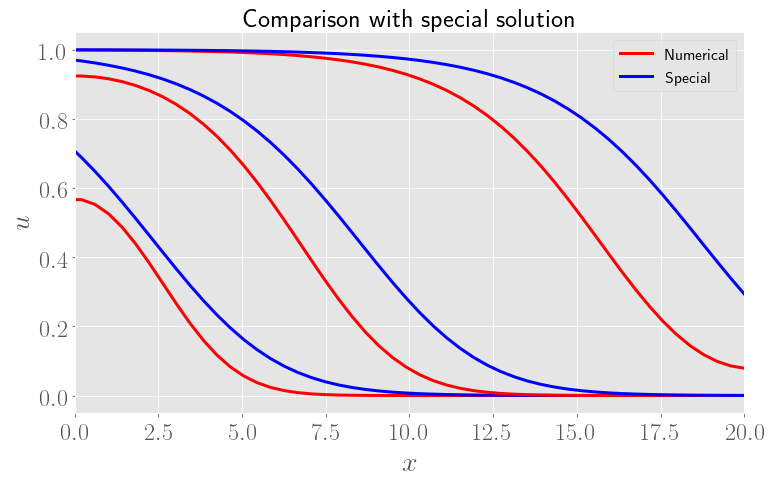

In [47]:
a = -20; b = 20; N = 100

plt.figure(figsize = (12, 7))

end_t_list = [2, 5, 10]
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)
    last_t = t_vals[-1]

    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
    y_vals = get_y_values(values, x_vals)
    if t == end_t_list[0]:
        plt.plot(x_vals, y_vals, color = 'red', label = 'Numerical')
    else:
        plt.plot(x_vals, y_vals, color = 'red')

    # Get special solution
    special_vals = special_solution_x_t(x_vals, last_t)
    if t == end_t_list[0]:
        plt.plot(x_vals, special_vals, color = 'blue', label = 'Special')
    else:
        plt.plot(x_vals, special_vals, color = 'blue')

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, 20)
plt.legend()
plt.title('Comparison with special solution')
plt.savefig('8_3_comparison_waves.pdf', bbox_inches = 'tight')
plt.show()

We can zoom in: this verifies the speeds are different (figure is not shown in the report).

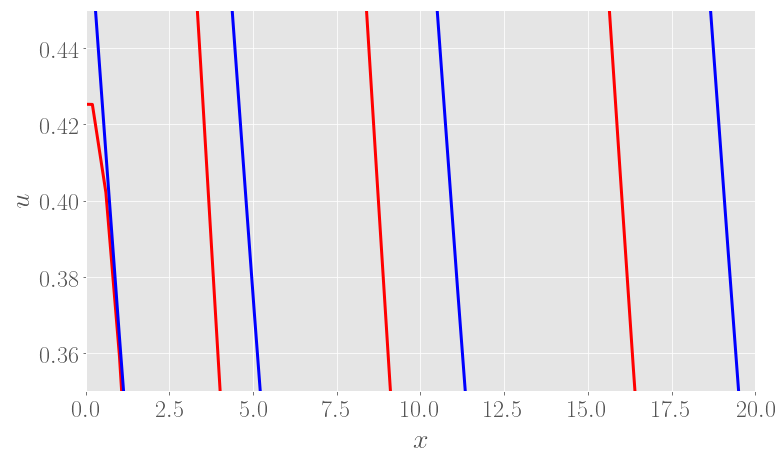

In [48]:
a = -20; b = 20; N = 100

plt.figure(figsize = (12, 7))

end_t_list = [1, 3, 6, 10]
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)
    last_t = t_vals[-1]

    # Get numerical values
    values, x_vals = solve_PDE(a, b, N, u_in, t_vals)
    y_vals = get_y_values(values, x_vals)
    plt.plot(x_vals, y_vals, color = 'red')

    # Get special solution
    special_vals = special_solution_x_t(x_vals, last_t)
    plt.plot(x_vals, special_vals, color = 'blue')

# Make fancy, save and show?
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, 20)
plt.ylim(0.35, 0.45)
#plt.legend()
plt.show()

We can compare with the approximate solution from 8.1.

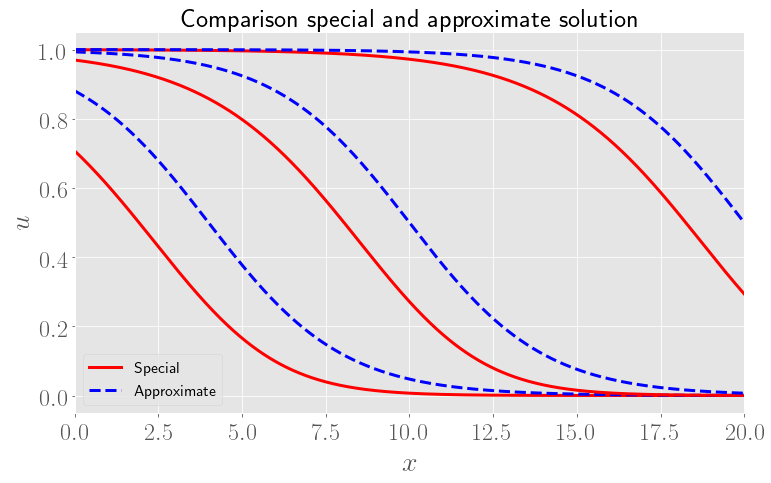

In [49]:
a = -20; b = 20; N = 100
x_vals = np.arange(0, 20, 0.001)

plt.figure(figsize = (12, 7))

end_t_list = [2, 5, 10]
for t in end_t_list:
    
    t_vals = np.arange(0, t, 0.001)
    last_t = t_vals[-1]

    # Get special solution
    special_vals = special_solution_x_t(x_vals, last_t)
    if t == end_t_list[0]:
        plt.plot(x_vals, special_vals, color = 'red', label = 'Special')
    else:
        plt.plot(x_vals, special_vals, color = 'red')
        
    # Compare with approximate solution
    last_t = t_vals[-1]
    approximate_vals = approximate_solution(x_vals, last_t)
    
    if t == end_t_list[0]:
        plt.plot(x_vals, approximate_vals, '--', color = 'blue', label = 'Approximate')
    else:
        plt.plot(x_vals, approximate_vals, '--', color = 'blue')

# Make fancy, save and show
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.xlim(0, 20)
plt.legend()
plt.title('Comparison special and approximate solution')
plt.savefig('8_3_comparison_approx_special.pdf', bbox_inches = 'tight')
plt.show()